In [27]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

import joblib

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
from sklearn.model_selection import train_test_split

### Pre-Fitted Voting Model

### Pipeline

In [4]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Automatic Aggregation

In [5]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

### File I/O

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes))
        
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

### Feature Engineering

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

### Configuration

In [21]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [26]:
TRAIN_DIR

PosixPath('/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train')

### Train Files Read & Feature Engineering

In [13]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
}

In [14]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 376)


### Feature Elimination

In [15]:
df_train = df_train.pipe(Pipeline.filter_cols)
# df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
# print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 267)


### Pandas Conversion

In [16]:
df_train, cat_cols = to_pandas(df_train)
# df_test, cat_cols = to_pandas(df_test, cat_cols)

### Garbage Collection

In [17]:
del data_store

gc.collect()

0

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 267 entries, case_id to max_num_group1_10
dtypes: bool(1), category(55), float64(204), int64(5), int8(2)
memory usage: 2.5 GB


In [19]:
df_train.columns

Index(['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision',
       'assignmentdate_238D', 'assignmentdate_4527235D', 'birthdate_574D',
       'contractssum_5085716L', 'dateofbirth_337D',
       ...
       'max_role_1084L', 'max_safeguarantyflag_411L', 'max_sex_738L',
       'max_type_25L', 'max_num_group1_8', 'max_amount_416A',
       'max_openingdate_313D', 'max_num_group1_9', 'max_openingdate_857D',
       'max_num_group1_10'],
      dtype='object', length=267)

### add cba_2

In [52]:
def cba_merge(n):
    cba_df = pd.read_parquet(TRAIN_DIR / f'train_credit_bureau_a_2_{n}.parquet')
    cba_df_merged = cba_df.groupby(['case_id']).agg({
        'pmts_dpd_1073P':'sum', 'pmts_dpd_303P':'sum',
        'pmts_overdue_1140A':'sum', 'pmts_overdue_1152A':'sum',
        'collater_valueofguarantee_1124L':'sum', 'collater_valueofguarantee_876L':'sum'})
    
    count_df = cba_df.groupby('num_group2').get_group(0).groupby('case_id').agg({'pmts_month_706T':'count', 'pmts_month_158T':'count'})
    cba_df_merged['num_closed'] = count_df['pmts_month_706T']
    cba_df_merged['num_active'] = count_df['pmts_month_158T']    

    del cba_df
    
    return cba_df_merged

In [55]:
cba_merge_0 = cba_merge(0)

In [56]:
cba_merge_1 = cba_merge(1)

In [57]:
cba_merge_2 = cba_merge(2)

In [58]:
cba_merge_3 = cba_merge(3)

In [59]:
cba_merge_4 = cba_merge(4)

In [60]:
cba_merge_5 = cba_merge(5)

In [61]:
cba_merge_6 = cba_merge(6)

In [62]:
cba_merge_7 = cba_merge(7)

In [63]:
cba_merge_8 = cba_merge(8)

In [64]:
cba_merge_9 = cba_merge(9)

In [65]:
cba_merge_10 = cba_merge(10)

In [66]:
cba_merge_list = []
for i in range(10+1):
    cba_merge_list.append(f'cba_merge_{i}')

In [67]:
cba_merge_list

['cba_merge_0',
 'cba_merge_1',
 'cba_merge_2',
 'cba_merge_3',
 'cba_merge_4',
 'cba_merge_5',
 'cba_merge_6',
 'cba_merge_7',
 'cba_merge_8',
 'cba_merge_9',
 'cba_merge_10']

In [76]:
cba_merged_all = pd.concat([cba_merge_0,
            cba_merge_1,
            cba_merge_2,
            cba_merge_3,
            cba_merge_4,
            cba_merge_5,
            cba_merge_6,
            cba_merge_7,
            cba_merge_8,
            cba_merge_9,
            cba_merge_10])

In [77]:
df_train_cba = pd.merge(df_train, cba_merged_all, on='case_id', how='left')

In [78]:
df_train_cba['dpd_isna'] = (df_train_cba['pmts_dpd_1073P'].isna()) & (df_train_cba['pmts_dpd_303P'].isna())
df_train_cba['overdue_isna'] = (df_train_cba['pmts_overdue_1140A'].isna()) & (df_train_cba['pmts_overdue_1152A'].isna())
df_train_cba['collateral_isna'] = (df_train_cba['collater_valueofguarantee_1124L'].isna()) & (df_train_cba['collater_valueofguarantee_876L'].isna())
df_train_cba['pmts_dpd_1073P'] = df_train_cba['pmts_dpd_1073P'].fillna(0)
df_train_cba['pmts_dpd_303P'] = df_train_cba['pmts_dpd_303P'].fillna(0)
df_train_cba['pmts_overdue_1140A'] = df_train_cba['pmts_overdue_1140A'].fillna(0)
df_train_cba['pmts_overdue_1152A'] = df_train_cba['pmts_overdue_1152A'].fillna(0)
df_train_cba['collater_valueofguarantee_1124L'] = df_train_cba['collater_valueofguarantee_1124L'].fillna(0)
df_train_cba['collater_valueofguarantee_876L'] = df_train_cba['collater_valueofguarantee_876L'].fillna(0)
df_train_cba['closed_contract_isna'] = df_train_cba['num_closed'].isna()
df_train_cba['active_contract_isna'] = df_train_cba['num_active'].isna()

In [79]:
df_train = df_train_cba

In [80]:
del cba_merge_0, cba_merge_1, cba_merge_2, cba_merge_3, cba_merge_4, cba_merge_5, cba_merge_6, cba_merge_7, cba_merge_8, cba_merge_9, cba_merge_10

### EDA

In [81]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

# print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
# print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)



### Training

In [82]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

## before downsampling

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [84]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [85]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.791237
[100]	valid_0's auc: 0.813479
[150]	valid_0's auc: 0.822589
[200]	valid_0's auc: 0.828558
[250]	valid_0's auc: 0.832167
[300]	valid_0's auc: 0.834522
[350]	valid_0's auc: 0.83648
[400]	valid_0's auc: 0.837893
[450]	valid_0's auc: 0.839105
[500]	valid_0's auc: 0.839978
[550]	valid_0's auc: 0.840802
[600]	valid_0's auc: 0.841481
[650]	valid_0's auc: 0.842324
[700]	valid_0's auc: 0.842875
[750]	valid_0's auc: 0.843292
[800]	valid_0's auc: 0.843694
[850]	valid_0's auc: 0.844118
[900]	valid_0's auc: 0.844508
Early stopping, best iteration is:
[925]	valid_0's auc: 0.844764


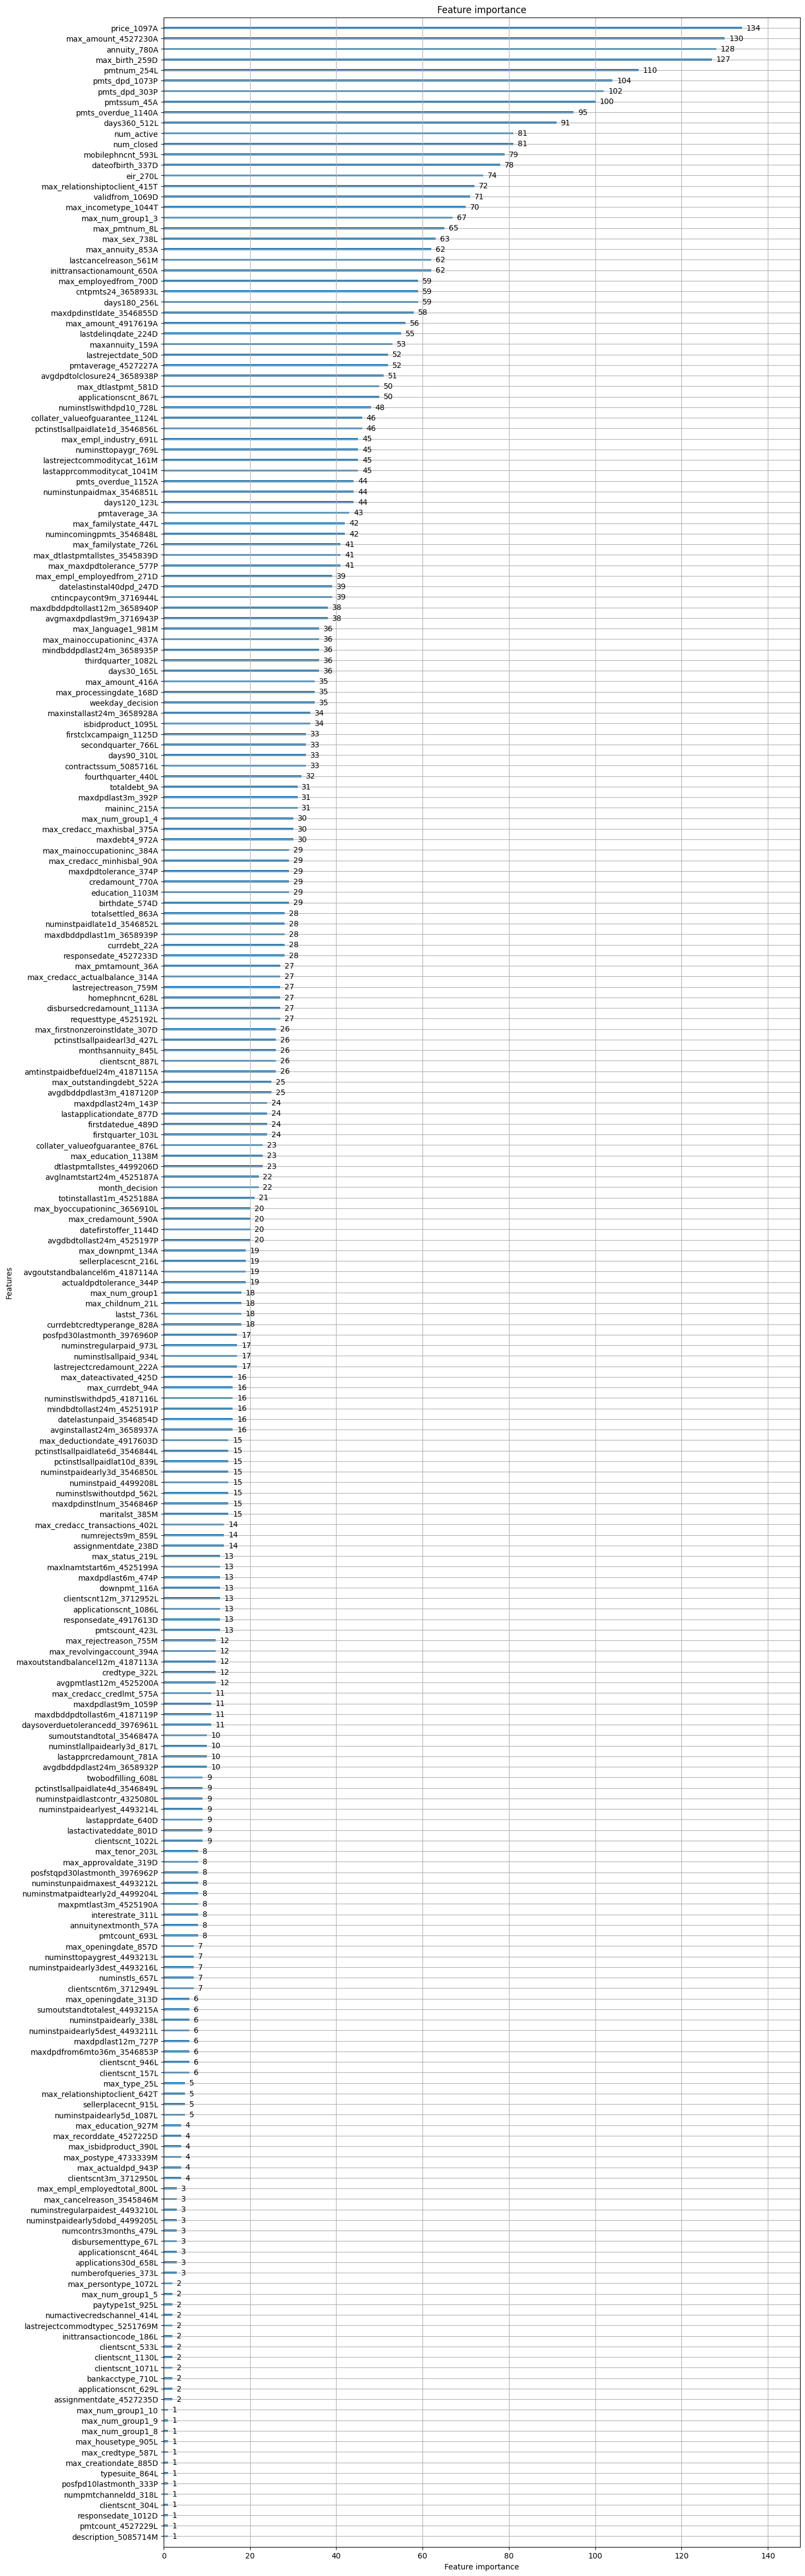

In [86]:
lgb.plot_importance(gbm, max_num_features=300, importance_type='split', figsize=(15, 60))
plt.show()

In [87]:
print(f'The AUC score on the train set is: {roc_auc_score(y_train, gbm.predict(X_train, num_iteration=gbm.best_iteration))}') 
print(f'The AUC score on the valid set is: {roc_auc_score(y_valid, gbm.predict(X_valid, num_iteration=gbm.best_iteration))}')
print(f'The AUC score on the test set is: {roc_auc_score(y_test, gbm.predict(X_test, num_iteration=gbm.best_iteration))}')  

The AUC score on the train set is: 0.859655006007739
The AUC score on the valid set is: 0.8447637494520402
The AUC score on the test set is: 0.8441574967721677


## downsampling 10:1

In [88]:
from sklearn.utils import resample

In [89]:
df_resampled = pd.concat([X, y], axis=1)
df_majority = df_resampled[df_resampled["target"] == 0]
df_minority = df_resampled[df_resampled["target"] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=int(len(df_minority) * 10), random_state=42)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X_downsampled = df_downsampled.drop(columns=["target"])
y_downsampled = df_downsampled["target"]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [91]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm2 = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.79656
[100]	valid_0's auc: 0.818046
[150]	valid_0's auc: 0.827328
[200]	valid_0's auc: 0.832907
[250]	valid_0's auc: 0.836242
[300]	valid_0's auc: 0.838635
[350]	valid_0's auc: 0.840562
[400]	valid_0's auc: 0.842038
[450]	valid_0's auc: 0.84352
[500]	valid_0's auc: 0.844397
[550]	valid_0's auc: 0.84518
[600]	valid_0's auc: 0.845832
[650]	valid_0's auc: 0.846353
[700]	valid_0's auc: 0.846809
Early stopping, best iteration is:
[735]	valid_0's auc: 0.847078


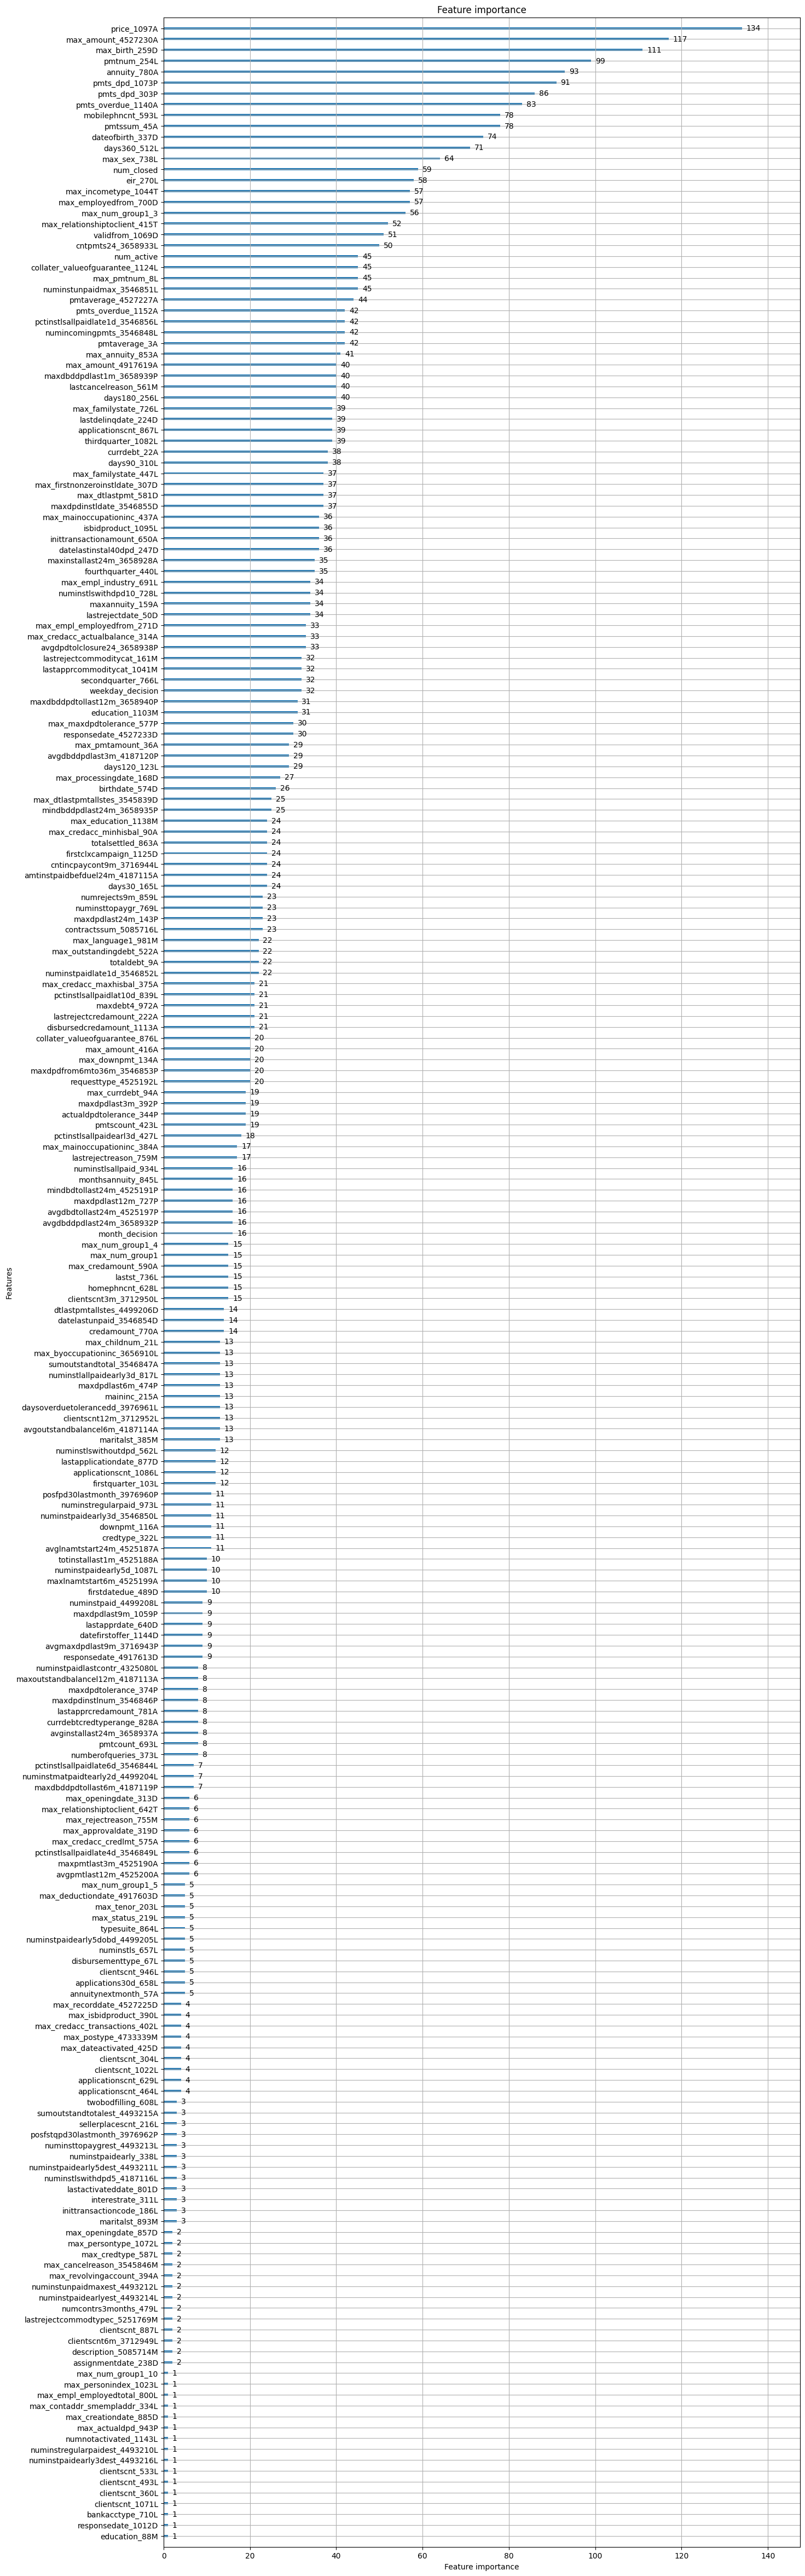

In [92]:
lgb.plot_importance(gbm2, max_num_features=300, importance_type='split', figsize=(15, 60))
plt.show()

In [93]:
print(f'The AUC score on the train set is: {roc_auc_score(y_train, gbm2.predict(X_train, num_iteration=gbm.best_iteration))}') 
print(f'The AUC score on the valid set is: {roc_auc_score(y_valid, gbm2.predict(X_valid, num_iteration=gbm.best_iteration))}')
print(f'The AUC score on the test set is: {roc_auc_score(y_test, gbm2.predict(X_test, num_iteration=gbm.best_iteration))}')  

The AUC score on the train set is: 0.856397954757517
The AUC score on the valid set is: 0.8470775421181085
The AUC score on the test set is: 0.8415771243896719


## downsampling 5:1

In [94]:
df_resampled = pd.concat([X, y], axis=1)
df_majority = df_resampled[df_resampled["target"] == 0]
df_minority = df_resampled[df_resampled["target"] == 1]
df_majority_downsampled2 = resample(df_majority, replace=False, n_samples=int(len(df_minority) * 5), random_state=42)
df_downsampled2 = pd.concat([df_majority_downsampled2, df_minority])

X_downsampled2 = df_downsampled2.drop(columns=["target"])
y_downsampled2 = df_downsampled2["target"]

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled2, y_downsampled2, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [96]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm3 = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.796493
[100]	valid_0's auc: 0.815326
[150]	valid_0's auc: 0.823329
[200]	valid_0's auc: 0.828143
[250]	valid_0's auc: 0.831181
[300]	valid_0's auc: 0.83335
[350]	valid_0's auc: 0.835162
[400]	valid_0's auc: 0.836413
[450]	valid_0's auc: 0.837638
[500]	valid_0's auc: 0.838624
[550]	valid_0's auc: 0.839172
[600]	valid_0's auc: 0.839954
[650]	valid_0's auc: 0.84048
[700]	valid_0's auc: 0.840953
[750]	valid_0's auc: 0.841419
[800]	valid_0's auc: 0.841741
Early stopping, best iteration is:
[800]	valid_0's auc: 0.841741


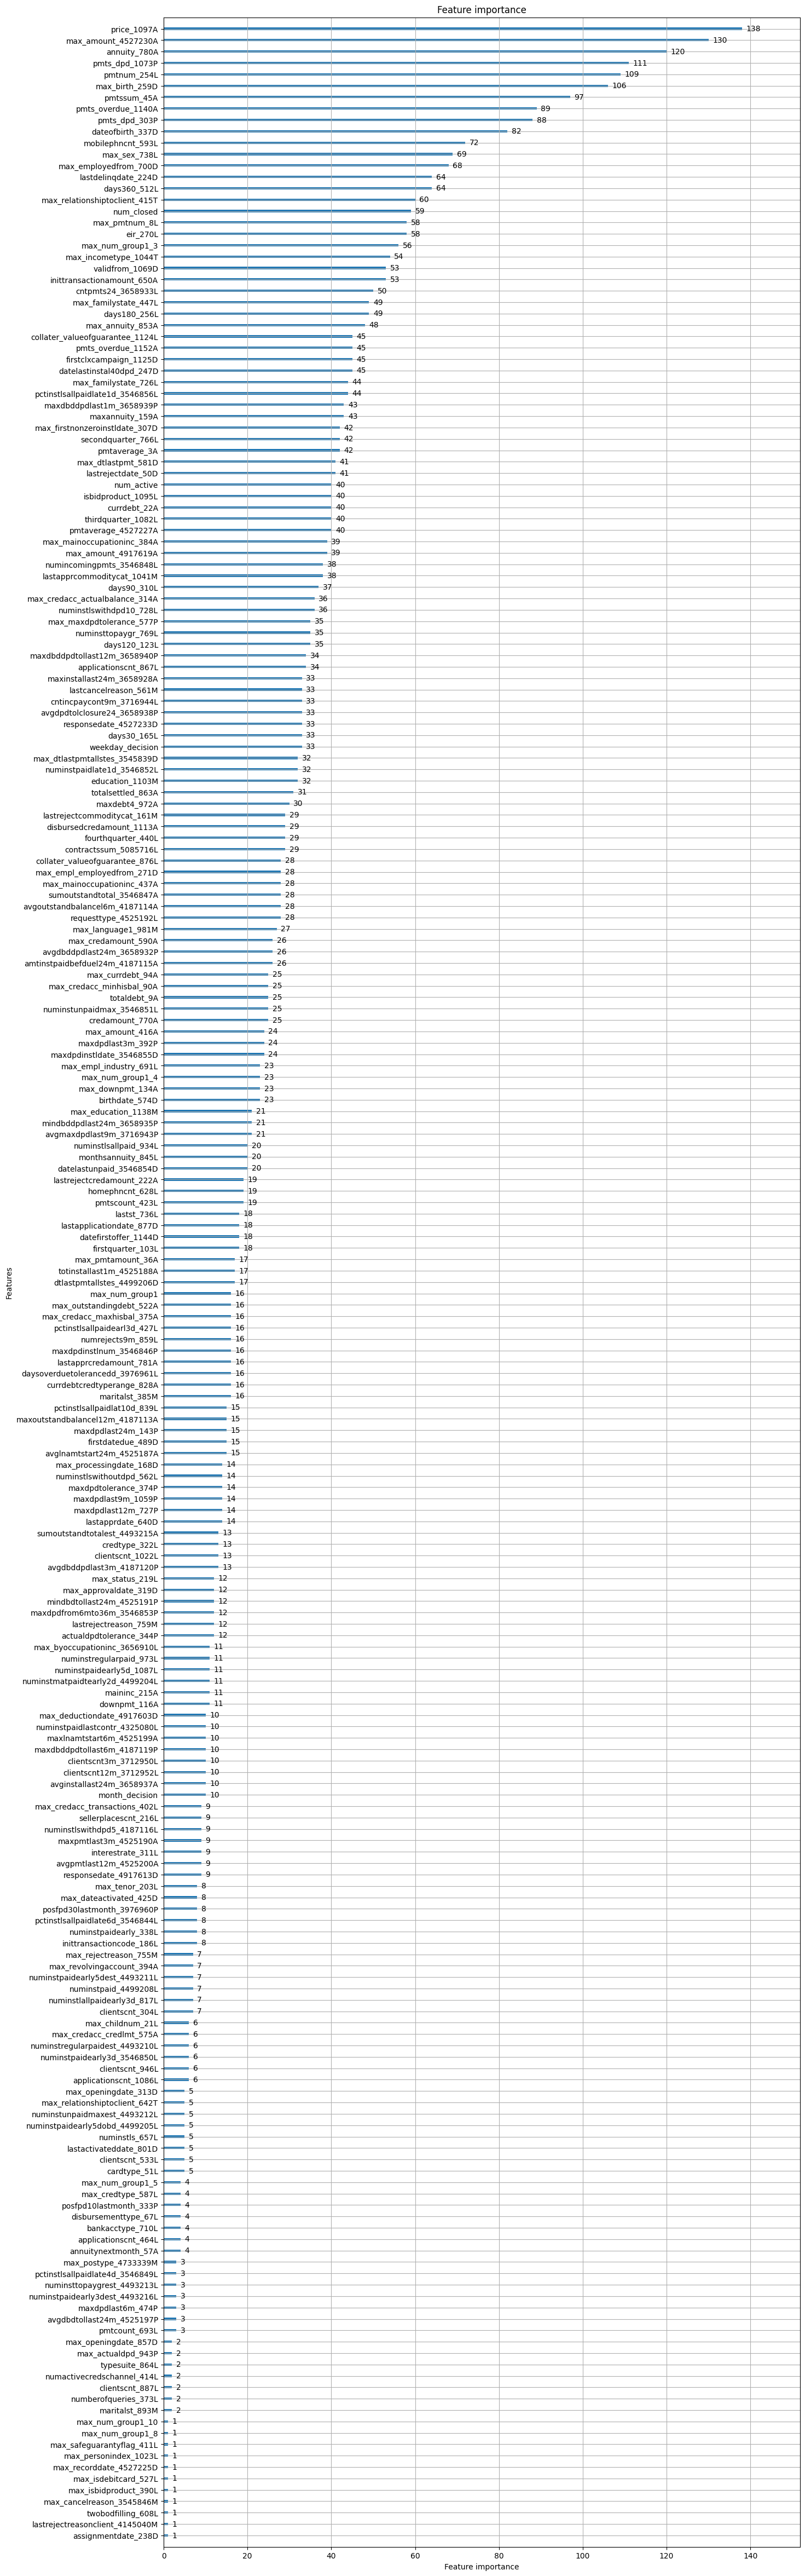

In [97]:
lgb.plot_importance(gbm3, max_num_features=300, importance_type='split', figsize=(15, 60))
plt.show()

In [98]:
print(f'The AUC score on the train set is: {roc_auc_score(y_train, gbm3.predict(X_train, num_iteration=gbm.best_iteration))}') 
print(f'The AUC score on the valid set is: {roc_auc_score(y_valid, gbm3.predict(X_valid, num_iteration=gbm.best_iteration))}')
print(f'The AUC score on the test set is: {roc_auc_score(y_test, gbm3.predict(X_test, num_iteration=gbm.best_iteration))}')  

The AUC score on the train set is: 0.8601366231053651
The AUC score on the valid set is: 0.8417413553102046
The AUC score on the test set is: 0.8466534956762986


## downsampling 1:1

In [99]:
df_resampled = pd.concat([X, y], axis=1)
df_majority = df_resampled[df_resampled["target"] == 0]
df_minority = df_resampled[df_resampled["target"] == 1]
df_majority_downsampled3 = resample(df_majority, replace=False, n_samples=int(len(df_minority) * 1), random_state=42)
df_downsampled3 = pd.concat([df_majority_downsampled3, df_minority])

X_downsampled3 = df_downsampled3.drop(columns=["target"])
y_downsampled3 = df_downsampled3["target"]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled3, y_downsampled3, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [101]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm4 = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.789171
[100]	valid_0's auc: 0.810227
[150]	valid_0's auc: 0.820052
[200]	valid_0's auc: 0.825403
[250]	valid_0's auc: 0.828487
[300]	valid_0's auc: 0.830806
[350]	valid_0's auc: 0.832841
[400]	valid_0's auc: 0.83458
[450]	valid_0's auc: 0.835775
[500]	valid_0's auc: 0.836577
[550]	valid_0's auc: 0.83717
[600]	valid_0's auc: 0.837922
[650]	valid_0's auc: 0.83854
[700]	valid_0's auc: 0.838879
[750]	valid_0's auc: 0.839332
Early stopping, best iteration is:
[759]	valid_0's auc: 0.839414


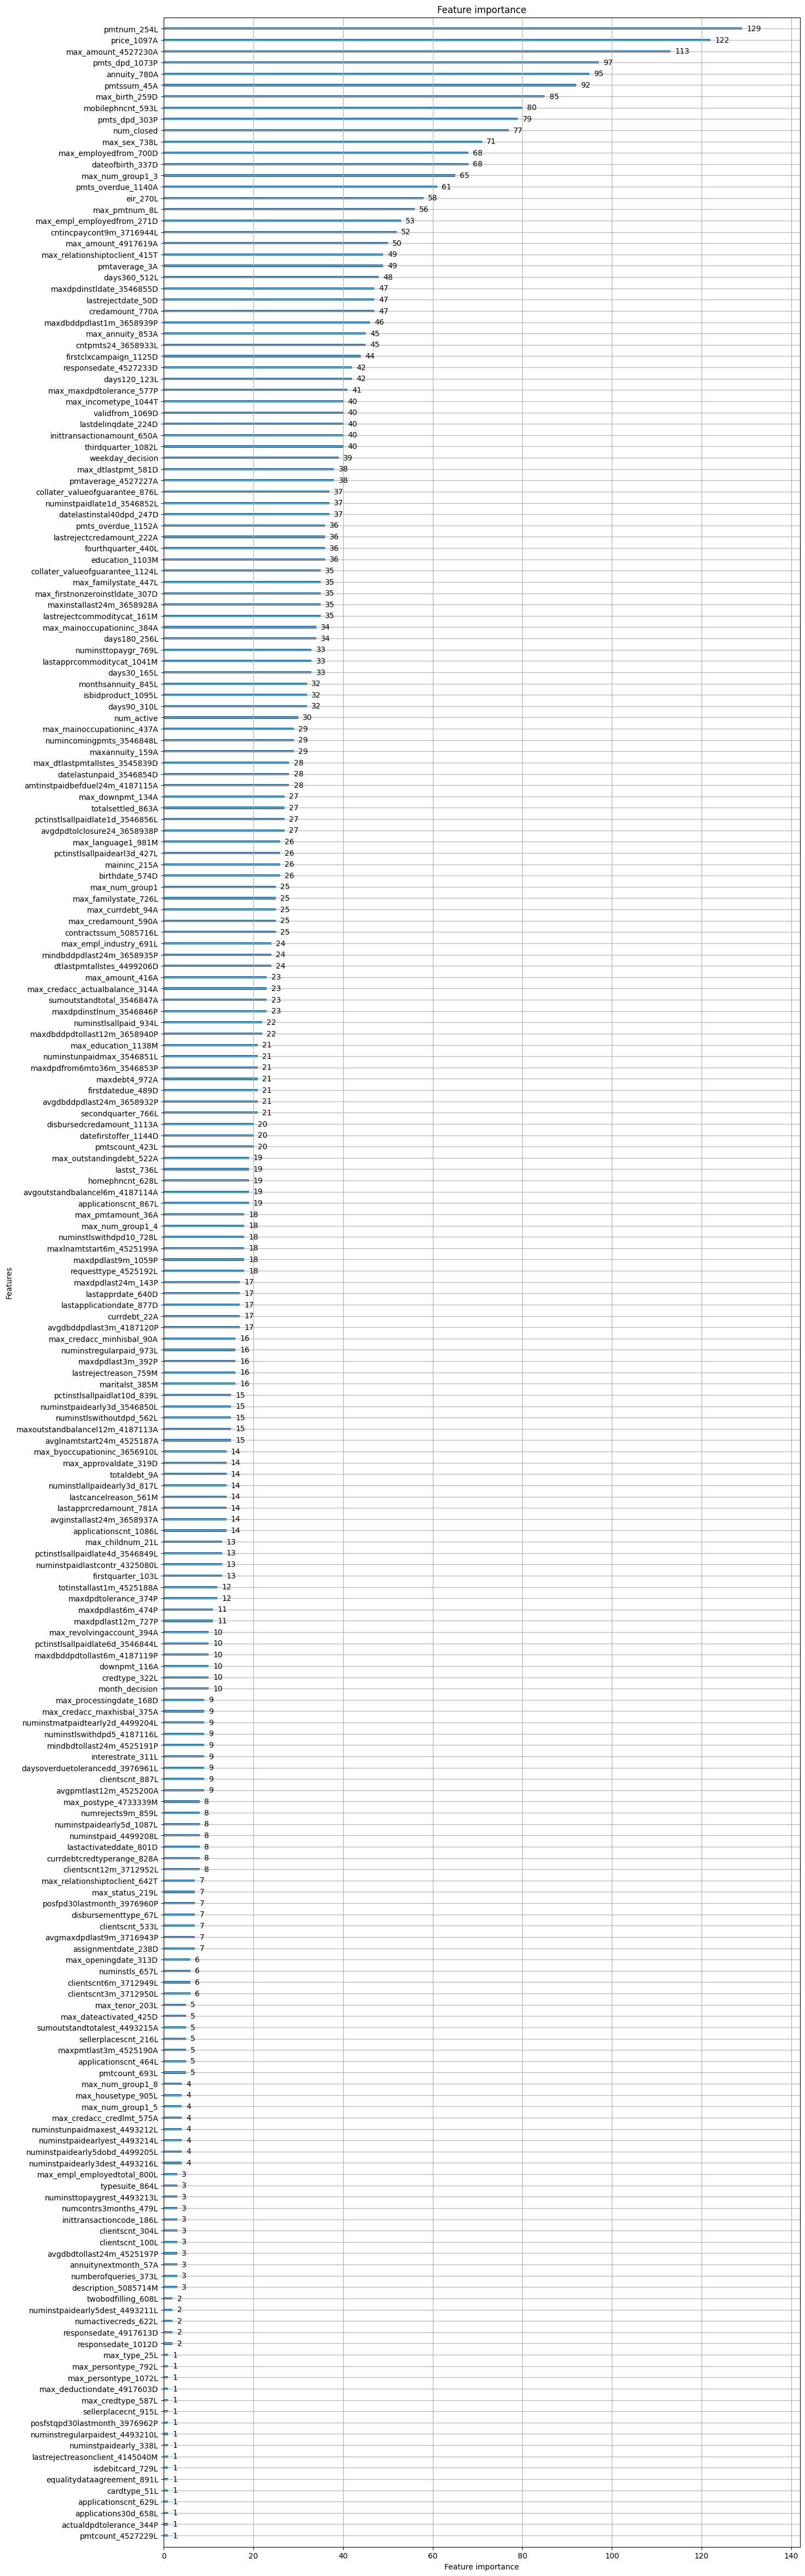

In [102]:
lgb.plot_importance(gbm4, max_num_features=300, importance_type='split', figsize=(15, 60))
plt.show()

In [103]:
print(f'The AUC score on the train set is: {roc_auc_score(y_train, gbm4.predict(X_train, num_iteration=gbm.best_iteration))}') 
print(f'The AUC score on the valid set is: {roc_auc_score(y_valid, gbm4.predict(X_valid, num_iteration=gbm.best_iteration))}')
print(f'The AUC score on the test set is: {roc_auc_score(y_test, gbm4.predict(X_test, num_iteration=gbm.best_iteration))}')  

The AUC score on the train set is: 0.8688595661267632
The AUC score on the valid set is: 0.8394135602582782
The AUC score on the test set is: 0.8412934162859664


### Prediction

In [ ]:
# X_test = df_test.drop(columns=["WEEK_NUM"])
# X_test = X_test.set_index("case_id")

# y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

### Submission

In [ ]:
# df_subm = pd.read_csv(ROOT / "sample_submission.csv")
# df_subm = df_subm.set_index("case_id")

# df_subm["score"] = y_pred

In [ ]:
# print("Check null: ", df_subm["score"].isnull().any())

# df_subm.head()

In [ ]:
# df_subm.to_csv("submission.csv")